In [11]:
import mne
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft #stft
from scipy.signal import butter, sosfiltfilt #signal filtering 
from scipy.interpolate import interp1d
import numpy as npy
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [12]:
file_path = "2025-08-16_15_12_26_Muse_Recording.csv"
#change to your file path

#Whole raw DF File
df = pd.read_csv(file_path)
df.head()

for col_name in df.columns:
    print(col_name)

print(df.shape)

PACKET_TYPE
PACKET_TIMESTAMP
CLOCK_TIME
ms_ELAPSED
TP9_CONNECTION_STRENGTH(HSI)
TP9_ARTIFACT_FREE(IS_GOOD)
AF7_CONNECTION_STRENGTH(HSI)
AF7_ARTIFACT_FREE(IS_GOOD)
AF8_CONNECTION_STRENGTH(HSI)
AF8_ARTIFACT_FREE(IS_GOOD)
TP10_CONNECTION_STRENGTH(HSI)
TP10_ARTIFACT_FREE(IS_GOOD)
TP9_RAW
AF7_RAW
AF8_RAW
TP10_RAW
TP9_DELTA_RELATIVE
AF7_DELTA_RELATIVE
AF8_DELTA_RELATIVE
TP10_DELTA_RELATIVE
TP9_THETA_RELATIVE
AF7_THETA_RELATIVE
AF8_THETA_RELATIVE
TP10_THETA_RELATIVE
TP9_ALPHA_RELATIVE
AF7_ALPHA_RELATIVE
AF8_ALPHA_RELATIVE
TP10_ALPHA_RELATIVE
TP9_BETA_RELATIVE
AF7_BETA_RELATIVE
AF8_BETA_RELATIVE
TP10_BETA_RELATIVE
TP9_GAMMA_RELATIVE
AF7_GAMMA_RELATIVE
AF8_GAMMA_RELATIVE
TP10_GAMMA_RELATIVE
730nm_LEFT_OUTER
730nm_RIGHT_OUTER
850nm_LEFT_OUTER
850nm_RIGHT_OUTER
730nm_LEFT_INNER
730nm_RIGHT_INNER
850nm_LEFT_INNER
850nm_RIGHT_INNER
RED_LEFT_OUTER
RED_RIGHT_OUTER
AMBIENT_LEFT_OUTER
AMBIENT_RIGHT_OUTER
RED_LEFT_INNER
RED_RIGHT_INNER
AMBIENT_LEFT_INNER
AMBIENT_RIGHT_INNER
BATTERY_PERCENT
(12767, 53)


Creating RawArray with float64 data, n_channels=4, n_times=12767
    Range : 0 ... 12766 =      0.000 ...    49.867 secs
Ready.
<Info | 8 non-empty values
 bads: []
 ch_names: TP9, AF7, AF8, TP10
 chs: 4 EEG
 custom_ref_applied: False
 dig: 7 items (3 Cardinal, 4 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 256.0 Hz
>
<RawArray | 4 x 12767 (49.9 s), ~410 KiB, data loaded>


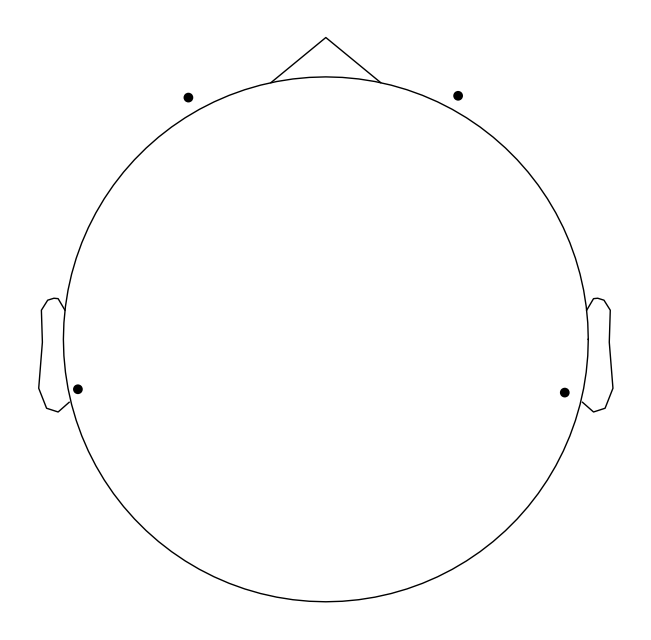

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/m/Desktop/Projects - Local/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/home/m/Desktop/Projects - Local/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/home/m/Desktop/Projects - Local/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/home/m/Desktop/Projects - Local/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/home/m/Desktop/Projects - Local/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


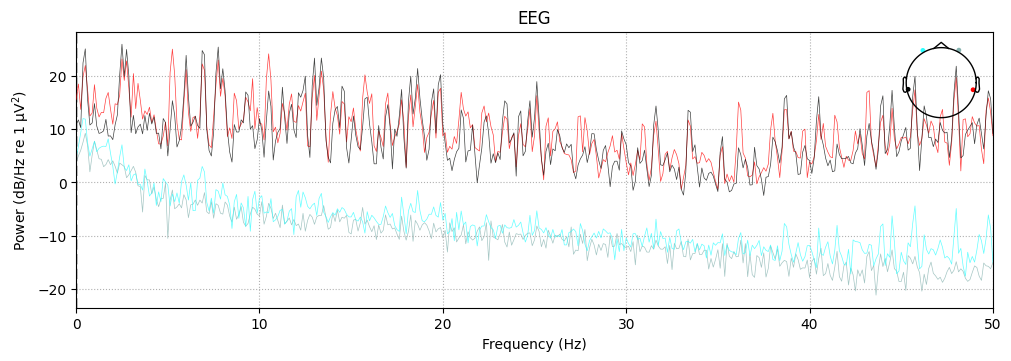

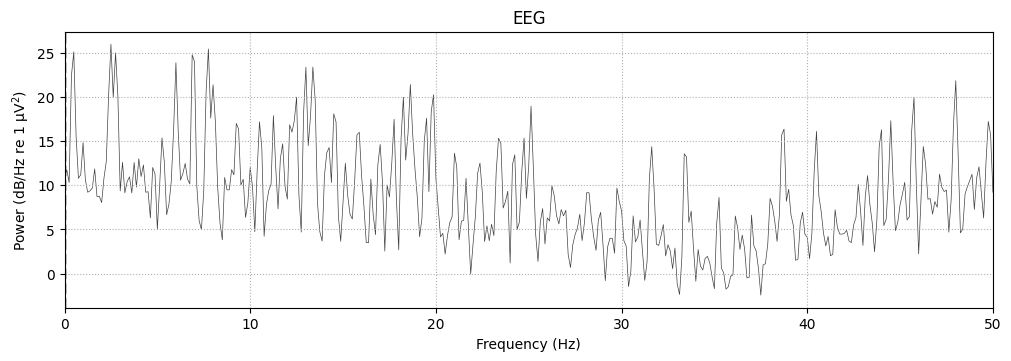

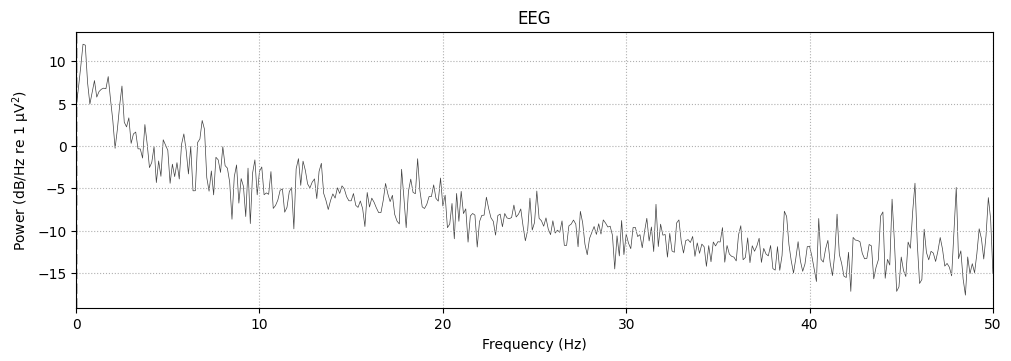

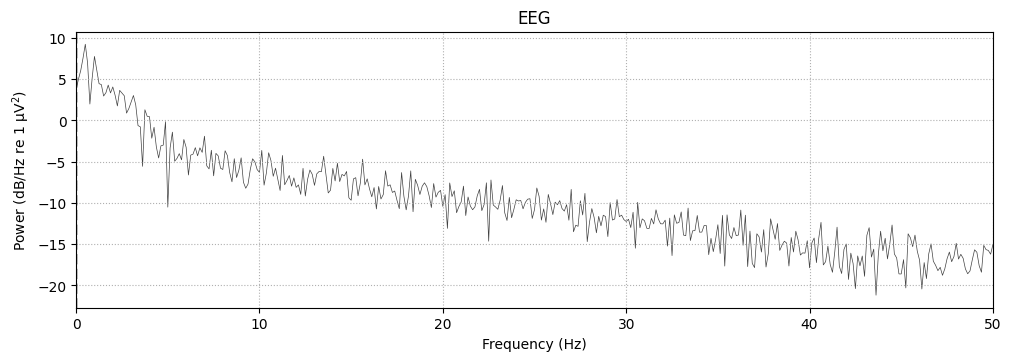

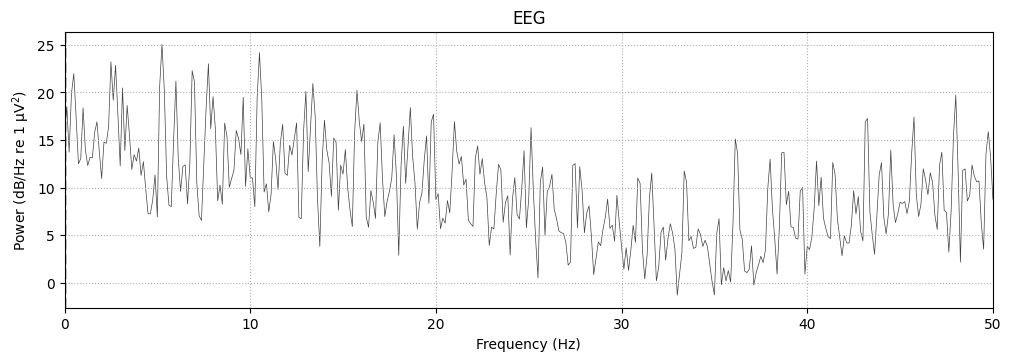

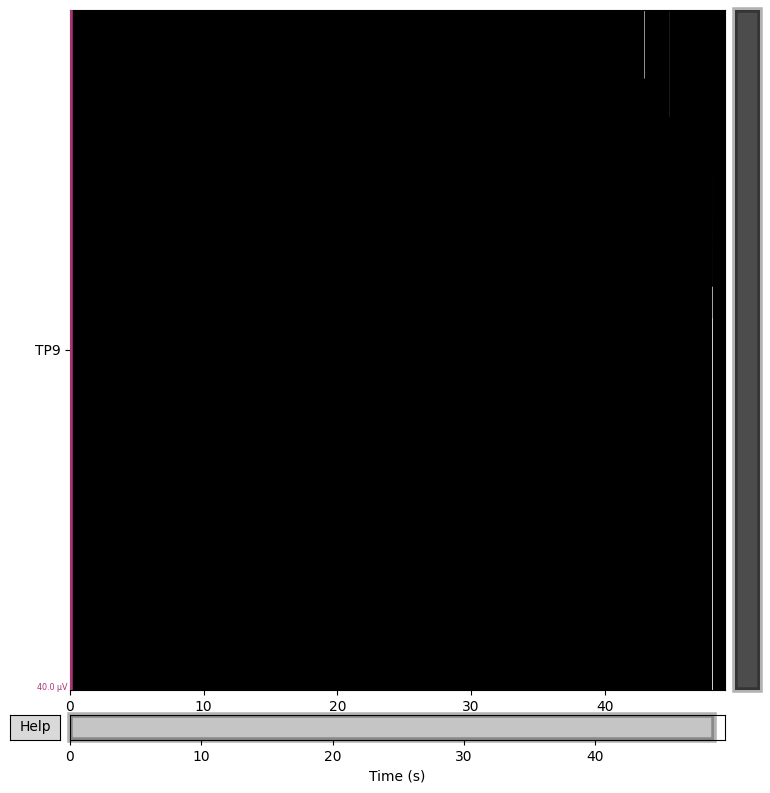

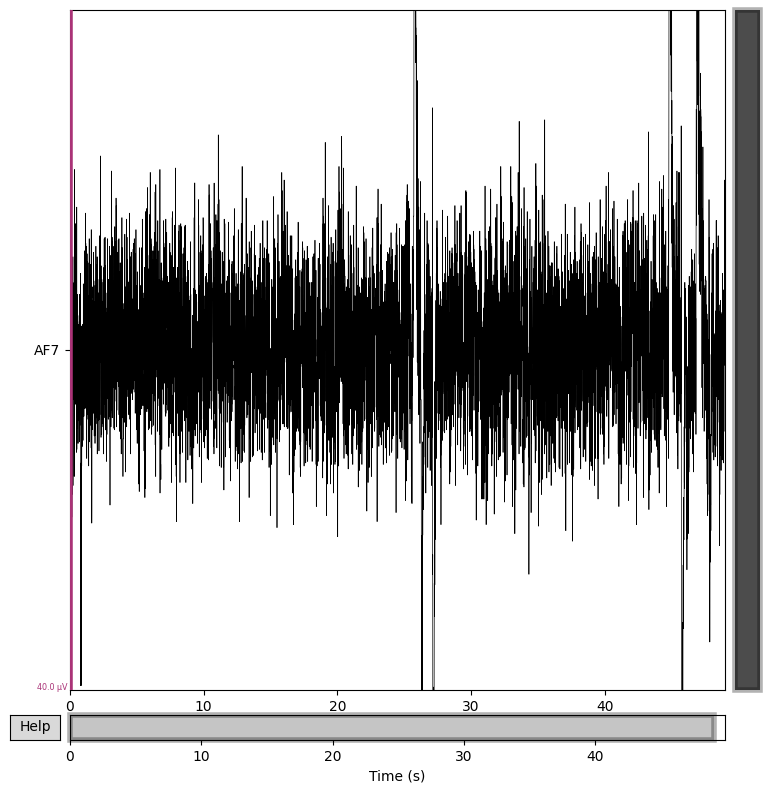

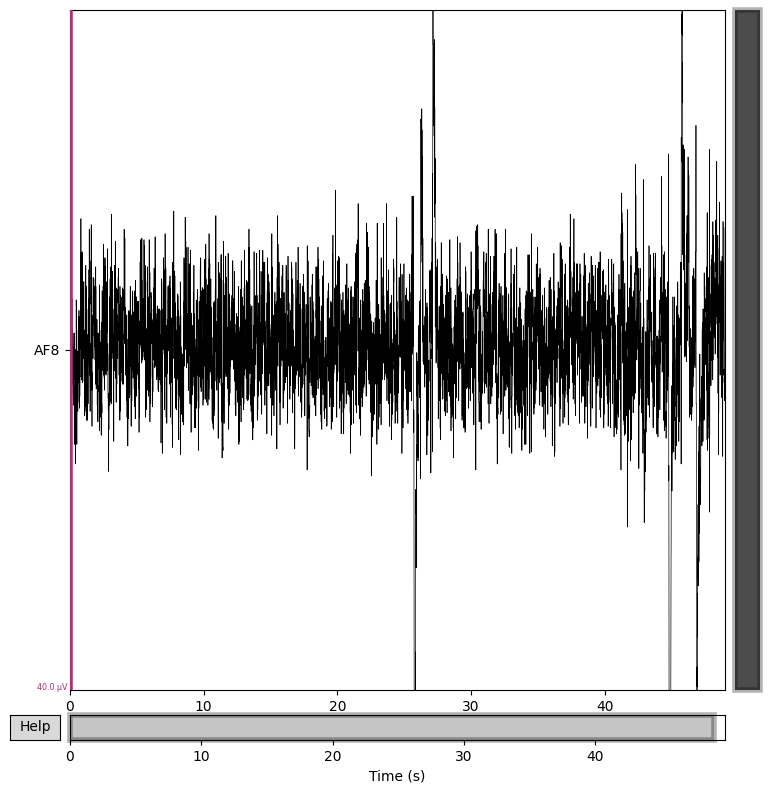

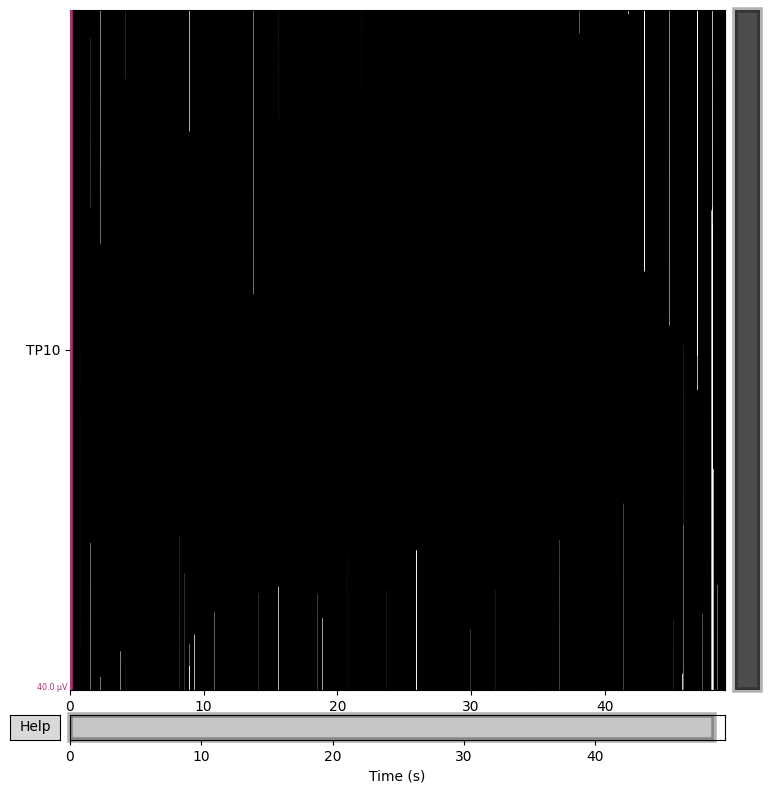

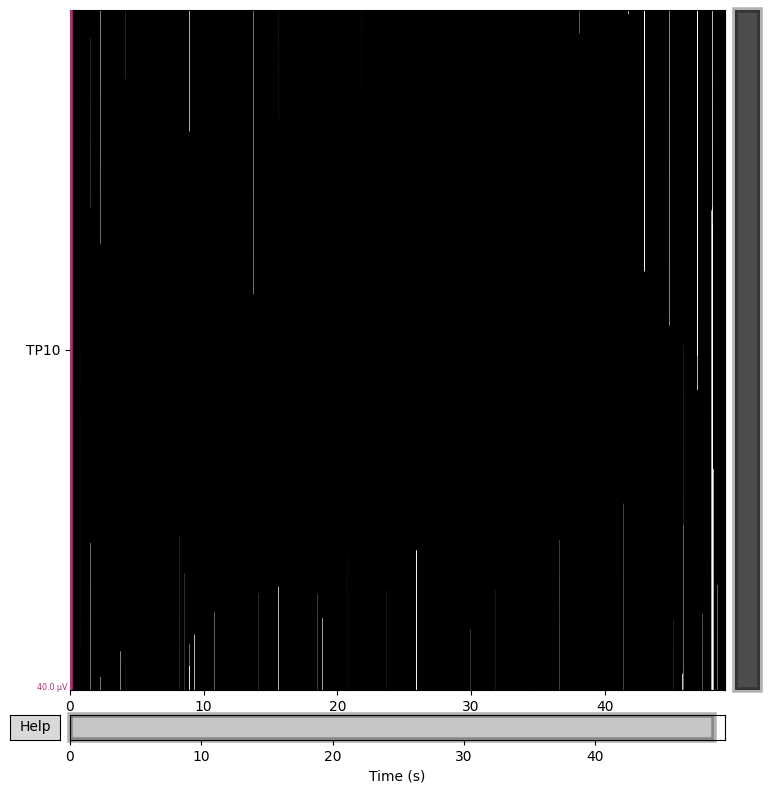

In [13]:
''' 
Unfiltered data! See filtered below. 
'''

#raw EEG only
rawEEG = pd.read_csv(file_path, usecols=['TP9_RAW', 'AF7_RAW', 'AF8_RAW', 'TP10_RAW'])

#printing the EEG file heads
#rawEEG.head()

#Set file Collumn Names
eeg_columns = ['TP9_RAW', 'AF7_RAW', 'AF8_RAW', 'TP10_RAW']  # Adjust to your column names

eeg_data = rawEEG[eeg_columns].values.T  # Transpose to (n_channels, n_samples)


'''
Keep in mind -> 

MU_01 (PRESET_AB/PRESET_AD)- >

    NO FILTERING, so see the code in the MU_01_500Hz folder. AUX electrodes should be shielded! 

MU_01 All other Presets -> 

    DRL/REF works, signal is filtered differently than other muses and comes thru at 220 Hz

All other Presets and Muses -> 

    Notch filter can be applied in app at 50/60Hz, default is 60Hz Raw EEG is at 256 Hz, 
    pre-calculated frequency bands are done on-device and are 10Hz. 

'''

#Create Info object
ch_names = ['TP9', 'AF7', 'AF8', 'TP10'] # Set channel names
#ch_names = ['TP9', 'AF7', 'AF8', 'TP10', "AUX_LEFT", "AUX_RIGHT"] # Set channel names to include AUX if you want
ch_types = ['eeg'] * len(ch_names) # Set channel types to EEG
sfreq = 256  # Sampling frequency in Hz (adjust to your data)

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

#Set montage for sensor positions
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

#turning data into volts from uV ajd creating raw object
data_volts = eeg_data * 1e-6
raw = mne.io.RawArray((data_volts), info)

#printing info 
print(raw.info)
print(raw)

#Plot EEG sensor locations 
raw.plot_sensors(ch_type="eeg")

#Plot PSD for all electrodes 
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)

#plot PSD by electrode 
raw.compute_psd(fmax=50).plot(picks="TP9", exclude="bads", amplitude=False)
raw.compute_psd(fmax=50).plot(picks="AF7", exclude="bads", amplitude=False)
raw.compute_psd(fmax=50).plot(picks="AF8", exclude="bads", amplitude=False)
raw.compute_psd(fmax=50).plot(picks="TP10", exclude="bads", amplitude=False)

#plot EEG by electrode
raw.plot(duration=49, n_channels=1, picks="TP9")
raw.plot(duration=49, n_channels=1, picks="AF7")
raw.plot(duration=49, n_channels=1, picks="AF8")
raw.plot(duration=49, n_channels=1, picks="TP10")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (33.004 s)

<Info | 8 non-empty values
 bads: []
 ch_names: TP9, AF7, AF8, TP10
 chs: 4 EEG
 custom_ref_applied: False
 dig: 7 items (3 Cardinal, 4 EEG)
 highpass: 0.1 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 256.0 Hz
>
<RawArray | 4 x 12767 (49.9 s), ~410 KiB, data loaded>


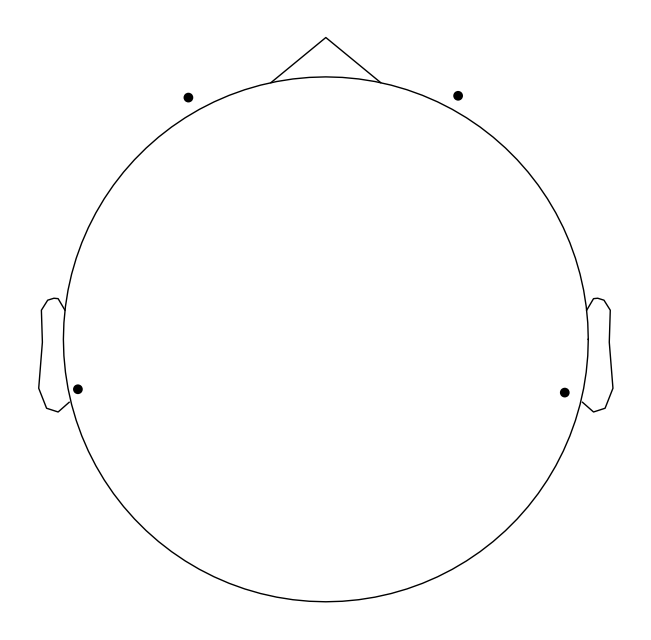

NameError: name 'total_length_seconds' is not defined

In [14]:
''' 
Filtered Data 
'''
#filtering raw 
# https://neuraldatascience.io/7-eeg/erp_filtering.html
# Filter settings
low_cut = 0.1
hi_cut  = 30
#apply filter - band pass from 0.1 - 30 Hz
filtered_raw = raw.copy().filter(low_cut, hi_cut)

#printing info 
print(filtered_raw.info)
print(raw)

#Plot EEG sensor locations 
filtered_raw.plot_sensors(ch_type="eeg")

#plot all filtered raw
filtered_raw.plot(start=0, duration=total_length_seconds);  # times are in seconds

#plot just the middle 
filtered_raw.plot(start=(total_length_seconds / 4), duration= (total_length_seconds / 4 * 3));  # times are in seconds

#plot EEG by electrode
filtered_raw.plot(duration=total_length_seconds, n_channels=1, picks="TP9")
filtered_raw.plot(duration=total_length_seconds, n_channels=1, picks="AF7")
filtered_raw.plot(duration=total_length_seconds, n_channels=1, picks="AF8")
filtered_raw.plot(duration=total_length_seconds, n_channels=1, picks="TP10")
filtered_raw.plot(duration=total_length_seconds, n_channels=1, picks="C3") #AUX Left
filtered_raw.plot(duration=total_length_seconds, n_channels=1, picks="C4") #AUX right

#Plot PSD, max freq is our nyquist freq
filtered_raw.compute_psd(fmax=60).plot(picks="data", exclude="bads", amplitude=False)